## Time series forecasting

Dataset: [Madrid weather dataset hourly 2019-2022](https://www.kaggle.com/datasets/rober2598/madrid-weather-dataset-by-hours-20192022/data)


Podaci sa meteorološke stanice Moratalaz u Madridu za period januar 2019-januar 2022.

Atributi:

1. temperature (ºC)
2. wind speed (m/s)
3. wind direction (in degrees)
4. humidity (%)
5. barometric pressure (mb)
6. solar radiation (W/m^2)
7. precipitation (l/m^2)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU

sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-whitegrid')

### Učitavanje i priprema podataka

In [2]:
data = pd.read_csv("weather_madrid_2019-2022.csv", index_col=1)

In [3]:
data.index = pd.to_datetime(data.index)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27024 entries, 2019-01-01 00:59:59 to 2022-01-31 23:59:59
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           27024 non-null  int64  
 1   temperature          27024 non-null  float64
 2   wind_speed           27024 non-null  float64
 3   wind_direction       27024 non-null  float64
 4   humidity             27024 non-null  float64
 5   barometric_pressure  27024 non-null  float64
 6   solar_radiation      27024 non-null  float64
 7   precipitation        27024 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 1.9 MB


In [5]:
print(f"Number of missing values in dataset:\n{data.isna().sum()}")

Number of missing values in dataset:
Unnamed: 0             0
temperature            0
wind_speed             0
wind_direction         0
humidity               0
barometric_pressure    0
solar_radiation        0
precipitation          0
dtype: int64


In [6]:
data.head()

,Unnamed: 0,temperature,wind_speed,wind_direction,humidity,barometric_pressure,solar_radiation,precipitation
time,,,,,,,,
2019-01-01 00:59:59,0,3.1,0.65,64.0,50.0,949.0,0.0,0.0
2019-01-01 01:59:59,1,2.9,0.95,32.0,49.0,949.0,0.0,0.0
2019-01-01 02:59:59,2,3.1,0.87,62.0,46.0,949.0,0.0,0.0
2019-01-01 03:59:59,3,1.9,0.73,75.0,51.0,949.0,0.0,0.0
2019-01-01 04:59:59,4,0.7,0.57,53.0,56.0,949.0,0.0,0.0


In [7]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
data.head()

,temperature,wind_speed,wind_direction,humidity,barometric_pressure,solar_radiation,precipitation
time,,,,,,,
2019-01-01 00:59:59,3.1,0.65,64.0,50.0,949.0,0.0,0.0
2019-01-01 01:59:59,2.9,0.95,32.0,49.0,949.0,0.0,0.0
2019-01-01 02:59:59,3.1,0.87,62.0,46.0,949.0,0.0,0.0
2019-01-01 03:59:59,1.9,0.73,75.0,51.0,949.0,0.0,0.0
2019-01-01 04:59:59,0.7,0.57,53.0,56.0,949.0,0.0,0.0


In [9]:
data.tail()

,temperature,wind_speed,wind_direction,humidity,barometric_pressure,solar_radiation,precipitation
time,,,,,,,
2022-01-31 19:59:59,10.1,2.65,47.0,17.0,946.0,0.0,0.0
2022-01-31 20:59:59,8.2,3.82,21.0,25.0,947.0,0.0,0.0
2022-01-31 21:59:59,7.2,2.38,29.0,31.0,947.0,0.0,0.0
2022-01-31 22:59:59,5.6,3.92,58.0,41.0,947.0,0.0,0.0
2022-01-31 23:59:59,4.9,3.95,11.0,47.0,948.0,0.0,0.0


In [10]:
data.describe()

,temperature,wind_speed,wind_direction,humidity,barometric_pressure,solar_radiation,precipitation
count,27024.000000,27024.000000,27024.000000,27024.000000,27024.000000,27024.000000,27024.000000
mean,12.817040,2.058503,142.523313,54.560909,940.013433,197.641282,0.045811
std,8.195516,1.253231,92.795447,22.700106,17.668038,284.877404,0.463671
min,-9.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.400000,1.100000,62.000000,36.000000,938.000000,0.000000,0.000000
50%,11.400000,1.800000,122.000000,53.000000,941.000000,9.000000,0.000000
75%,18.800000,2.770000,241.000000,72.000000,944.000000,355.000000,0.000000
max,37.900000,9.450000,359.000000,100.000000,952.000000,1068.000000,27.400000


In [11]:
data.skew()

temperature             0.461747
wind_speed              1.008883
wind_direction          0.248713
humidity                0.152653
barometric_pressure   -29.898869
solar_radiation         1.311261
precipitation          30.785920
dtype: float64

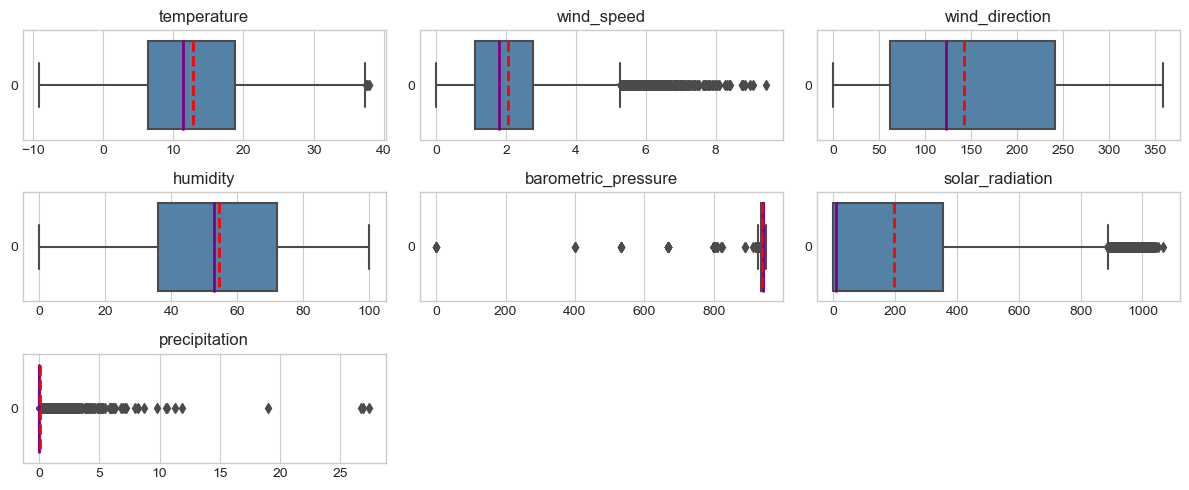

In [12]:
plt.figure(figsize=(12, 5))
for i, feature in enumerate(list(data.columns)):
    plt.subplot(3, 3, i+1)
    plt.title(feature)
    sns.boxplot(data[feature], orient='h', color="steelblue", showmeans=True, meanline=True,
                    medianprops={'linewidth': 2, 'color': 'purple'},
                    meanprops={'linewidth': 2, 'color': 'red'})
plt.tight_layout()

In [13]:
Q1 = data['barometric_pressure'].quantile(0.25)
Q3 = data['barometric_pressure'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

upper_array = data[data['barometric_pressure'] >= upper].index
lower_array = data[data['barometric_pressure'] <= lower].index

mean = data.loc[:, 'barometric_pressure'].mean()
data.loc[upper_array, 'barometric_pressure'] = mean
data.loc[lower_array, 'barometric_pressure'] = mean

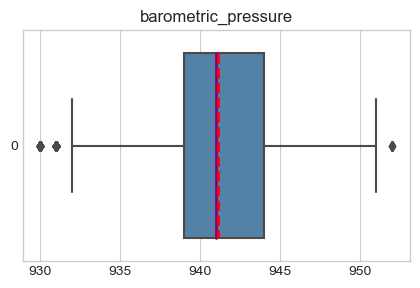

In [14]:
plt.figure(figsize=(5, 3))
plt.title("barometric_pressure")
sns.boxplot(data["barometric_pressure"], orient='h', color="steelblue", showmeans=True, meanline=True,
                    medianprops={'linewidth': 2, 'color': 'purple'},
                    meanprops={'linewidth': 2, 'color': 'red'})
plt.show()

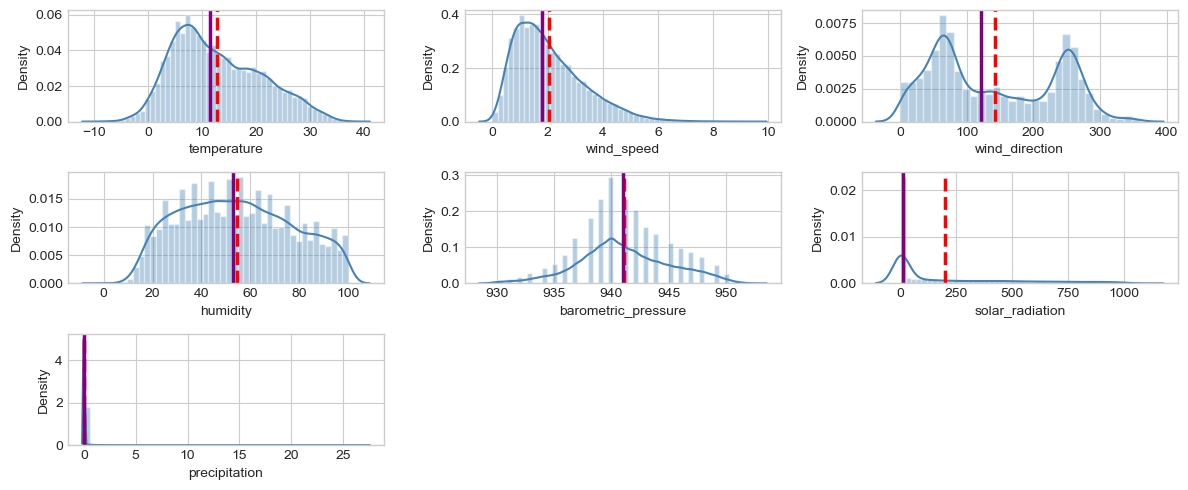

In [15]:
plt.figure(figsize=(12, 5))
for i, feature in enumerate(list(data.columns)):
    plt.subplot(3, 3, i+1)
    sns.distplot(data[feature], color="steelblue")
    plt.axvline(x=data[feature].mean(), c='red', ls='--', lw=2.5)
    plt.axvline(x=data[feature].median(), c='purple', ls='-', lw=2.5)
plt.tight_layout()

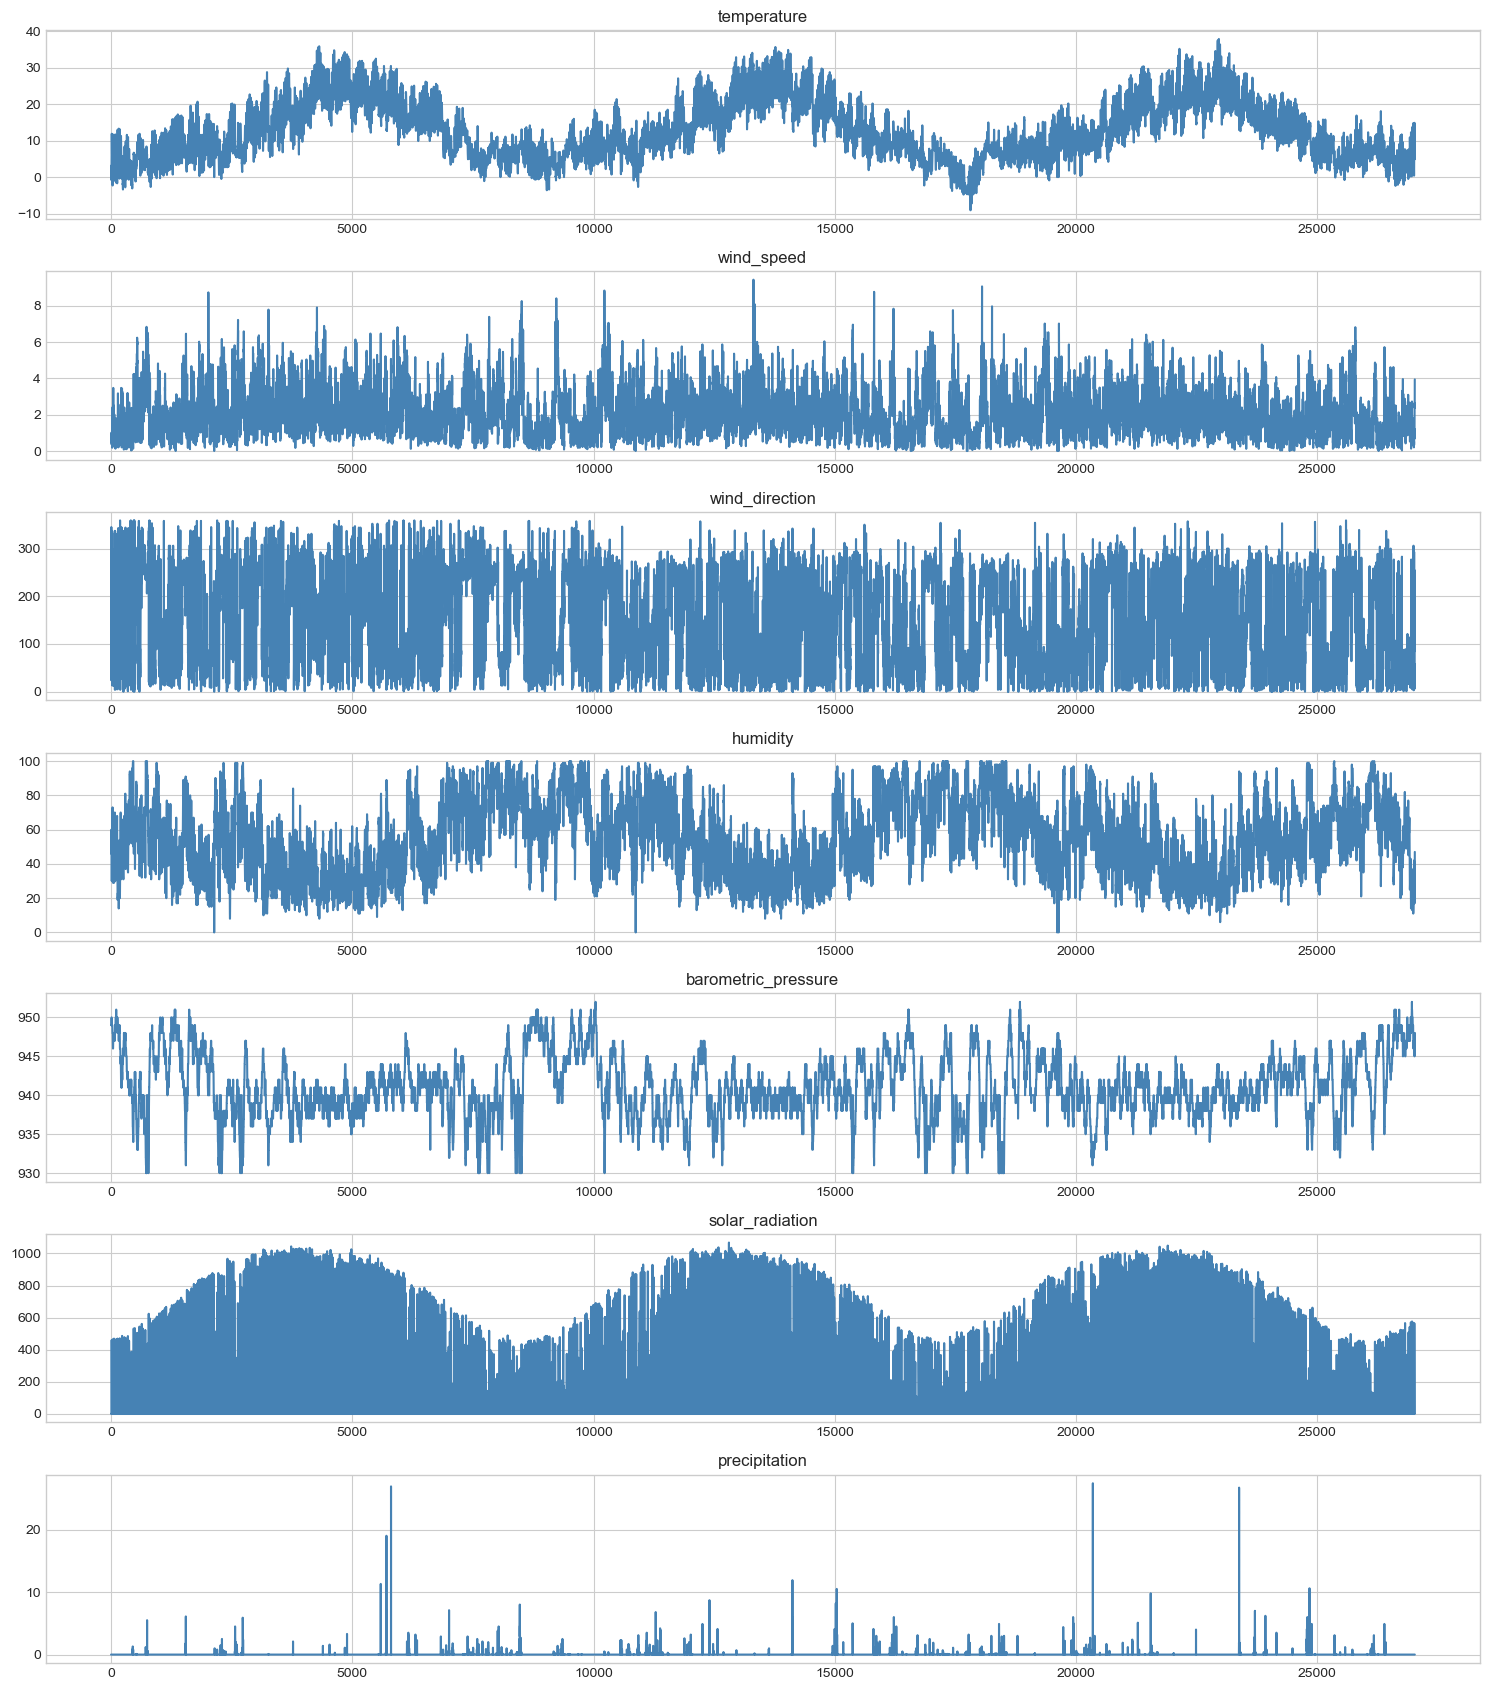

In [16]:
plt.figure(figsize=(15, 17))
for i, feature in enumerate(list(data.columns)):
    plt.subplot(7, 1, i+1)
    plt.title(feature)
    plt.plot(data[feature].values, color="steelblue")
plt.tight_layout()

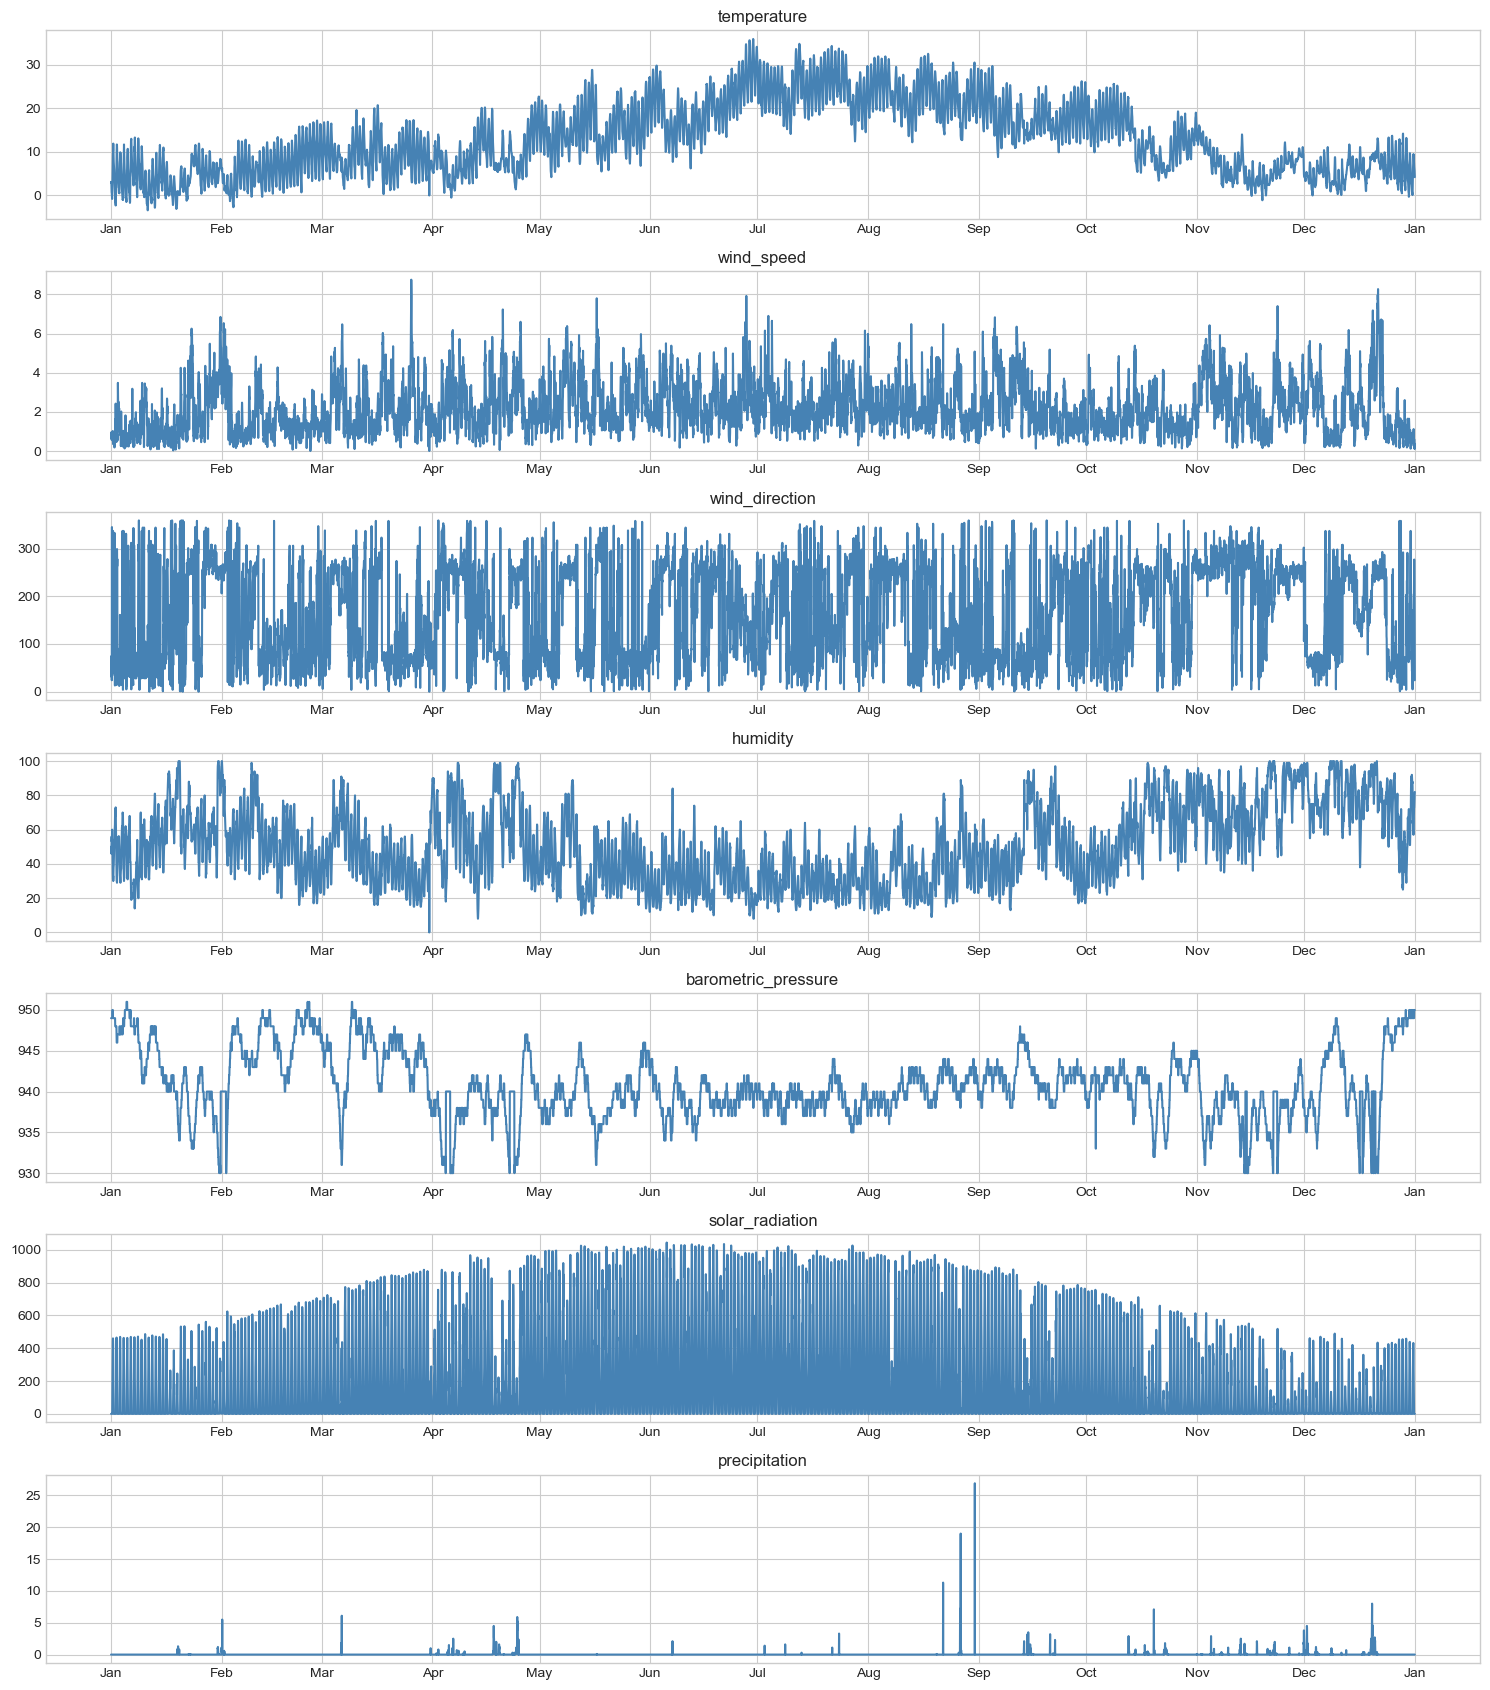

In [17]:
plt.figure(figsize=(15, 17))
for i, feature in enumerate(list(data.columns)):
    ax = plt.subplot(7, 1, i+1)
    plt.title(feature)
    plt.plot(list(data.index.values[0:365*24]), data[feature].values[0:365*24], color="steelblue")
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.tight_layout()

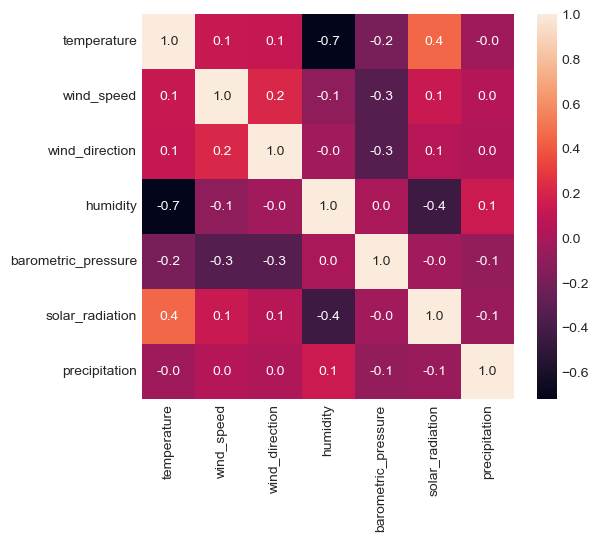

In [18]:
plt.figure(figsize=(6, 5))
sns.heatmap(data.corr(), annot = True, fmt='.1f')
plt.show()

### Helpers

In [19]:
def series_to_supervised(data, index, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    df.index = index
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
        
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)

    return agg

In [20]:
def evaluate_model(model, scaler, test_X, test_y):
    pred_y = model.predict(test_X)

    test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    inv_pred_y = np.concatenate((pred_y, test_X[:, 1:]), axis=1)
    inv_pred_y = scaler.inverse_transform(inv_pred_y)
    inv_pred_y = inv_pred_y[:, 0]

    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:, 0]

    rmse = math.sqrt(mean_squared_error(inv_y, inv_pred_y))
    print('Test RMSE: %.3f' % rmse)

    return inv_y, inv_pred_y

In [21]:
def visualize_predictions(time, n_train_hours, train_y, test_y, pred_y):
    plt.figure(figsize=(15, 15))

    plt.subplot(3, 1, 1)
    plt.title("Train + Test")
    plt.plot(time[:n_train_hours], train_y, label = "train_data", color = "b")
    plt.plot(time[n_train_hours:], pred_y, label = "test_data", color = "g")
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.title("True vs Predicted")
    plt.plot(time[n_train_hours:], test_y, label = "true", color = "g")
    plt.plot(time[n_train_hours:], pred_y, label = "predicted", color = "r")
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.title("True vs Predicted")
    plt.plot(time[n_train_hours:n_train_hours+10*24], test_y[:10*24], label = "true", color = "g")
    plt.plot(time[n_train_hours:n_train_hours+10*24], pred_y[:10*24], label = "predicted", color = "r")
    plt.legend()

    plt.show()

### Univariate forecasting

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data.drop(['wind_speed', 'wind_direction', 'humidity',
       'barometric_pressure', 'solar_radiation', 'precipitation'], axis=1))

reframed = series_to_supervised(scaled, data.index, 1, 1)

In [23]:
reframed.head()

,var1(t-1),var1(t)
time,,
2019-01-01 01:59:59,0.259574,0.255319
2019-01-01 02:59:59,0.255319,0.259574
2019-01-01 03:59:59,0.259574,0.234043
2019-01-01 04:59:59,0.234043,0.208511
2019-01-01 05:59:59,0.208511,0.204255


In [24]:
values = reframed.values
n_train_hours = 2 * 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

train_X, train_y = train[:, :-1], train[:, -1]
train_y = train_y.reshape((len(train_y), 1))
inv_train_y = np.concatenate((train_y, train_X[:, 1:]), axis=1)
inv_train_y = scaler.inverse_transform(inv_train_y)
inv_train_y = inv_train_y[:, 0]

new_n_train_hours = n_train_hours - 3 * 30 * 24
val = train[new_n_train_hours:, :]
train = train[:new_n_train_hours, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, val_X.shape, val_y.shape)

(15360, 1, 1) (15360,) (9503, 1, 1) (9503,) (2160, 1, 1) (2160,)


#### SimpleRNN



Epoch 1/50

240/240 - 4s - loss: 0.0040 - val_loss: 0.0031 - 4s/epoch - 17ms/step
Epoch 2/50
240/240 - 1s - loss: 9.5070e-04 - val_loss: 6.1927e-04 - 598ms/epoch - 2ms/step
Epoch 3/50
240/240 - 1s - loss: 5.3201e-04 - val_loss: 3.2220e-04 - 593ms/epoch - 2ms/step
Epoch 4/50
240/240 - 1s - loss: 4.8642e-04 - val_loss: 3.0429e-04 - 724ms/epoch - 3ms/step
Epoch 5/50
240/240 - 1s - loss: 4.8332e-04 - val_loss: 2.9783e-04 - 628ms/epoch - 3ms/step
Epoch 6/50
240/240 - 1s - loss: 4.8357e-04 - val_loss: 2.9266e-04 - 611ms/epoch - 3ms/step
Epoch 7/50
240/240 - 1s - loss: 4.8457e-04 - val_loss: 2.9275e-04 - 573ms/epoch - 2ms/step
Epoch 8/50
240/240 - 1s - loss: 4.8602e-04 - val_loss: 2.9239e-04 - 592ms/epoch - 2ms/step
Epoch 9/50
240/240 - 1s - loss: 4.8756e-04 - val_loss: 2.9757e-04 - 600ms/epoch - 2ms/step
Epoch 10/50
240/240 - 1s - loss: 4.8876e-04 - val_loss: 3.0745e-04 - 562ms/epoch - 2ms/step
Epoch 11/50
240/240 - 1s - loss: 4.8904e-04 - val_loss: 3.0668e-04 - 579ms/epoch - 2ms/step
Epoc

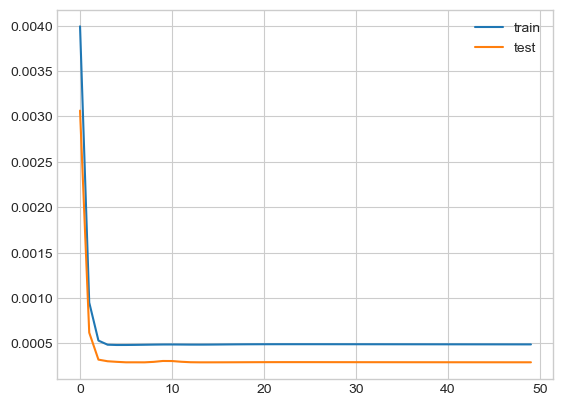

In [25]:
model = Sequential()
model.add(SimpleRNN(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(val_X, val_y), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [26]:
inv_test_y, inv_pred_y = evaluate_model(model, scaler, test_X, test_y)

297/297 [==============================] - 1s 2ms/step
Test RMSE: 1.044


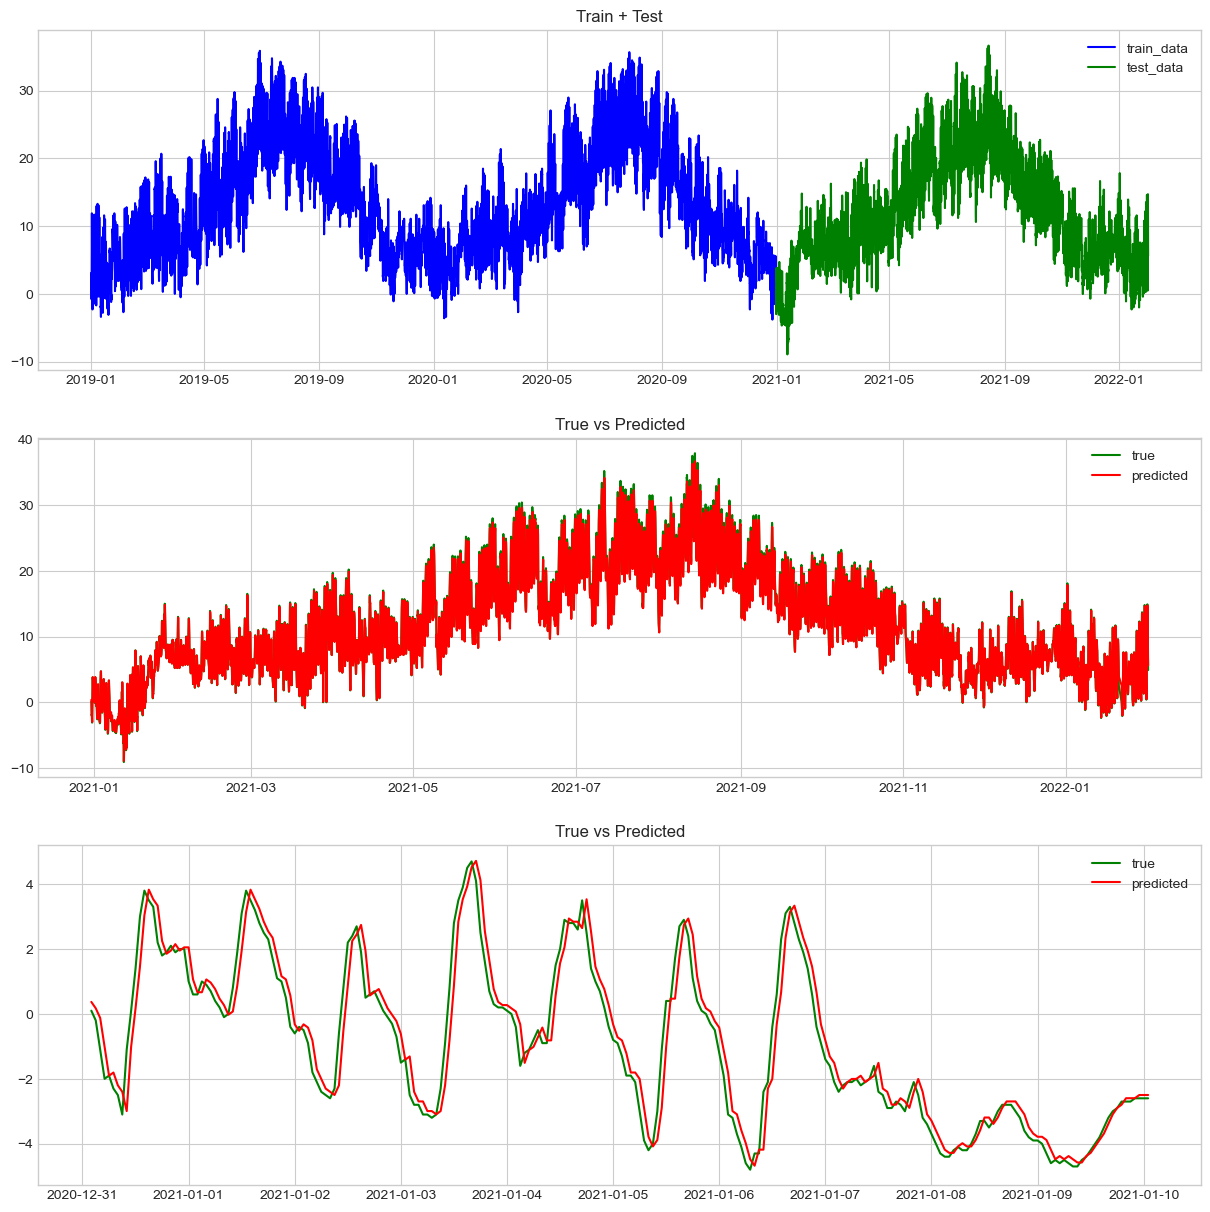

In [27]:
visualize_predictions(reframed.index, n_train_hours, inv_train_y, inv_test_y, inv_pred_y)

#### LSTM RNN 

Epoch 1/50
240/240 - 10s - loss: 0.0315 - val_loss: 0.0317 - 10s/epoch - 40ms/step
Epoch 2/50
240/240 - 1s - loss: 0.0079 - val_loss: 0.0178 - 1s/epoch - 4ms/step
Epoch 3/50
240/240 - 1s - loss: 0.0044 - val_loss: 0.0099 - 1s/epoch - 5ms/step
Epoch 4/50
240/240 - 1s - loss: 0.0026 - val_loss: 0.0055 - 1s/epoch - 5ms/step
Epoch 5/50
240/240 - 1s - loss: 0.0016 - val_loss: 0.0032 - 1s/epoch - 6ms/step
Epoch 6/50
240/240 - 1s - loss: 0.0011 - val_loss: 0.0018 - 1s/epoch - 5ms/step
Epoch 7/50
240/240 - 1s - loss: 7.8114e-04 - val_loss: 0.0011 - 1s/epoch - 5ms/step
Epoch 8/50
240/240 - 2s - loss: 6.3479e-04 - val_loss: 7.5304e-04 - 2s/epoch - 7ms/step
Epoch 9/50
240/240 - 1s - loss: 5.6516e-04 - val_loss: 5.5909e-04 - 1s/epoch - 5ms/step
Epoch 10/50
240/240 - 1s - loss: 5.3467e-04 - val_loss: 4.6229e-04 - 1s/epoch - 5ms/step
Epoch 11/50
240/240 - 1s - loss: 5.2209e-04 - val_loss: 4.1574e-04 - 1s/epoch - 5ms/step
Epoch 12/50
240/240 - 2s - loss: 5.1690e-04 - val_loss: 3.9460e-04 - 2s/epoch -

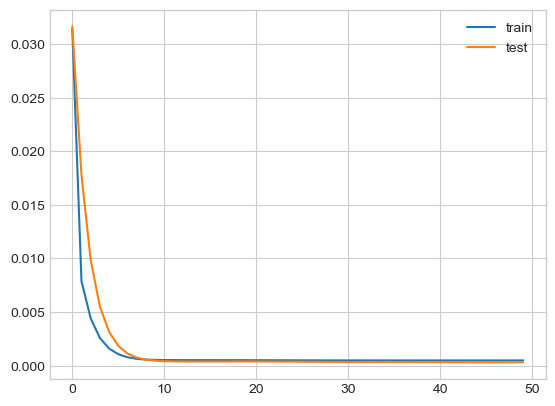

In [28]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(val_X, val_y), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [29]:
inv_test_y, inv_pred_y = evaluate_model(model, scaler, test_X, test_y)

297/297 [==============================] - 2s 3ms/step
Test RMSE: 1.039


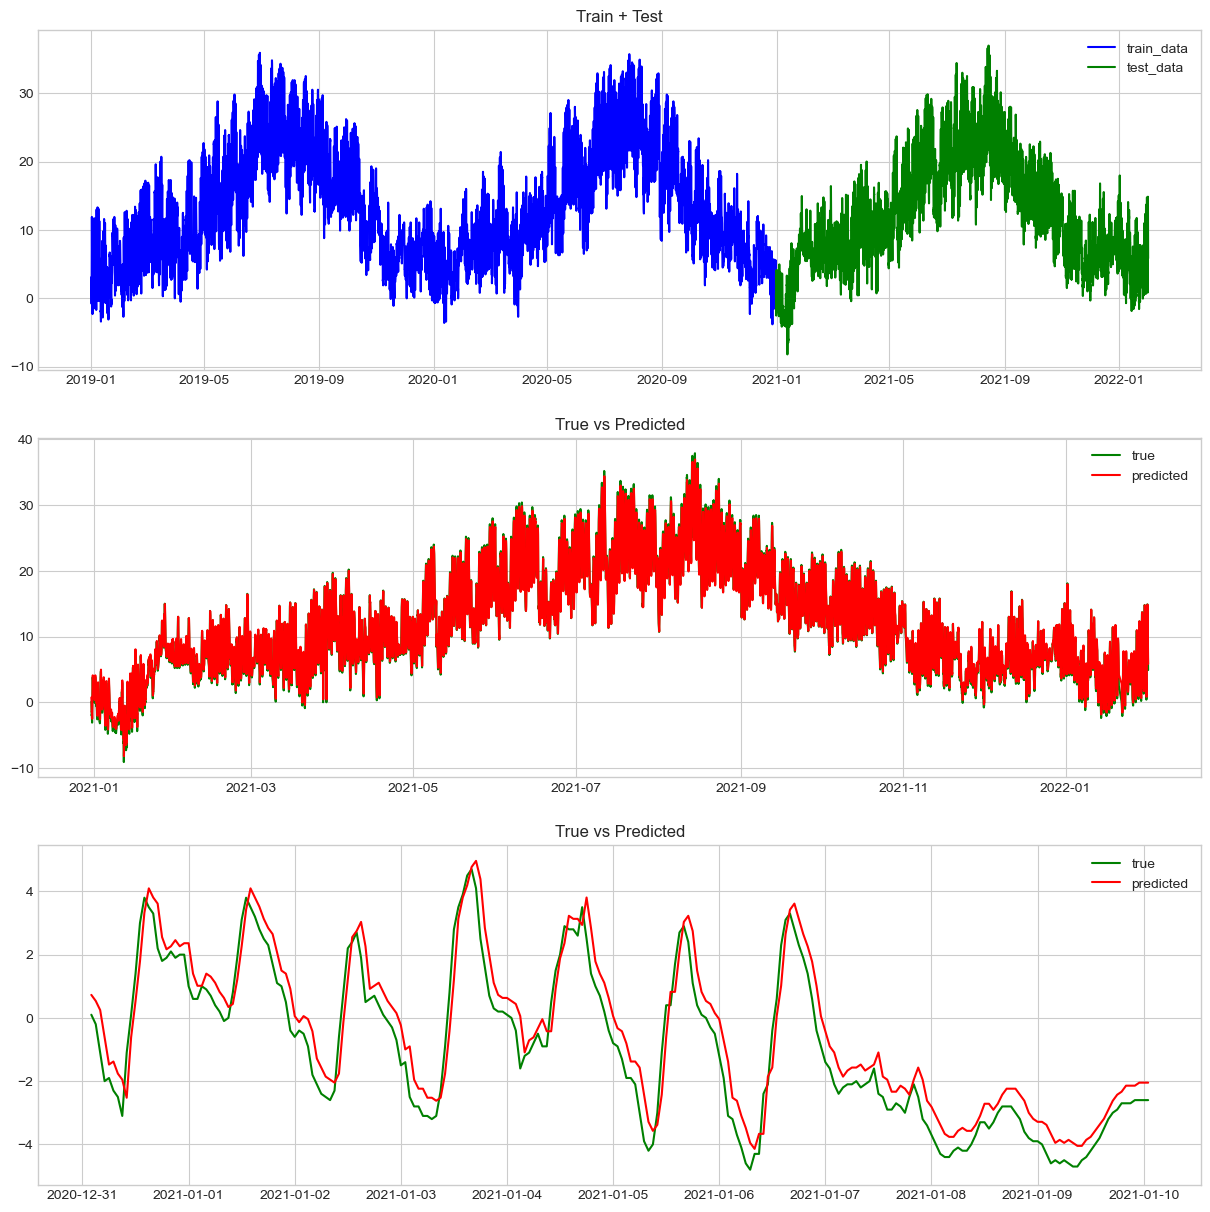

In [30]:
visualize_predictions(reframed.index, n_train_hours, inv_train_y, inv_test_y, inv_pred_y)

#### GRU RNN

Epoch 1/50
240/240 - 6s - loss: 0.0155 - val_loss: 0.0221 - 6s/epoch - 26ms/step
Epoch 2/50
240/240 - 1s - loss: 0.0053 - val_loss: 0.0113 - 795ms/epoch - 3ms/step
Epoch 3/50
240/240 - 1s - loss: 0.0029 - val_loss: 0.0056 - 847ms/epoch - 4ms/step
Epoch 4/50
240/240 - 1s - loss: 0.0016 - val_loss: 0.0025 - 820ms/epoch - 3ms/step
Epoch 5/50
240/240 - 1s - loss: 8.8885e-04 - val_loss: 0.0010 - 770ms/epoch - 3ms/step
Epoch 6/50
240/240 - 1s - loss: 5.9997e-04 - val_loss: 5.1658e-04 - 764ms/epoch - 3ms/step
Epoch 7/50
240/240 - 1s - loss: 5.1398e-04 - val_loss: 3.8438e-04 - 753ms/epoch - 3ms/step
Epoch 8/50
240/240 - 1s - loss: 4.9495e-04 - val_loss: 3.5205e-04 - 748ms/epoch - 3ms/step
Epoch 9/50
240/240 - 1s - loss: 4.9113e-04 - val_loss: 3.4347e-04 - 753ms/epoch - 3ms/step
Epoch 10/50
240/240 - 1s - loss: 4.9041e-04 - val_loss: 3.4148e-04 - 772ms/epoch - 3ms/step
Epoch 11/50
240/240 - 1s - loss: 4.9018e-04 - val_loss: 3.4356e-04 - 754ms/epoch - 3ms/step
Epoch 12/50
240/240 - 1s - loss: 4.

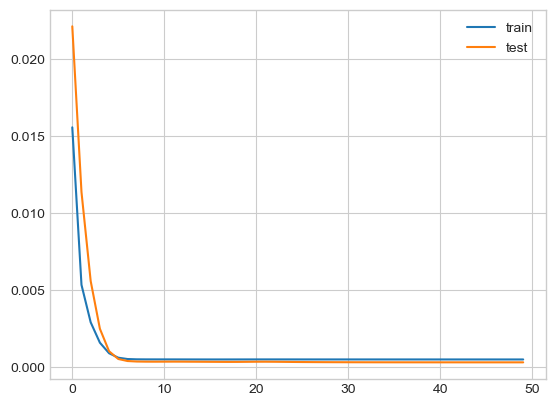

In [31]:
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(val_X, val_y), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [32]:
inv_test_y, inv_pred_y = evaluate_model(model, scaler, test_X, test_y)

297/297 [==============================] - 2s 3ms/step
Test RMSE: 1.045


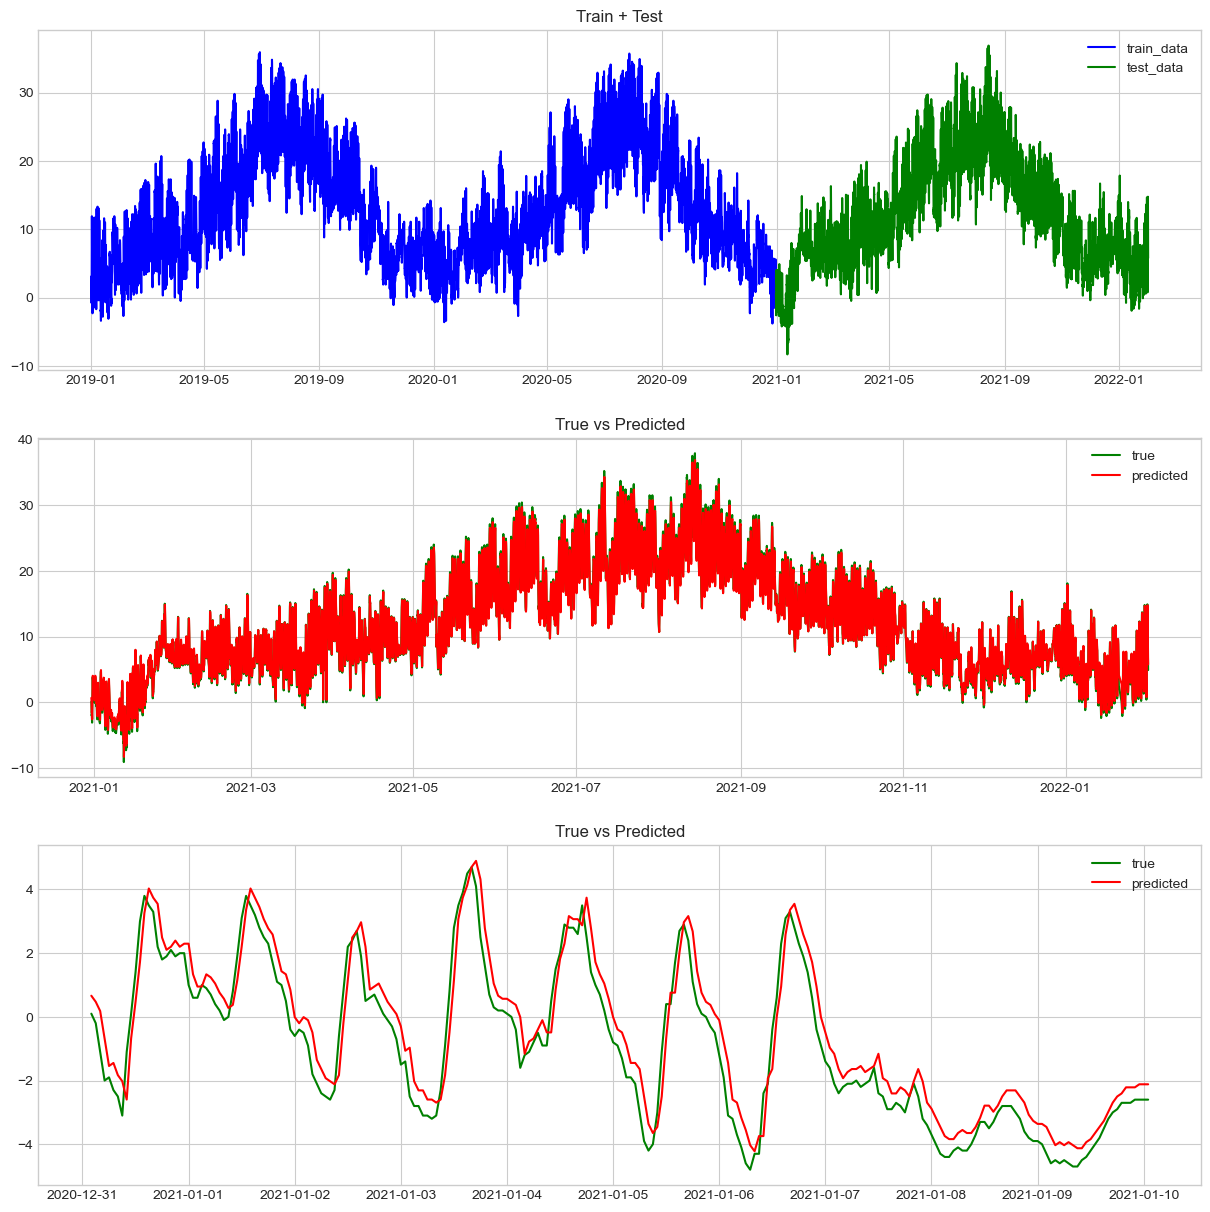

In [33]:
visualize_predictions(reframed.index, n_train_hours, inv_train_y, inv_test_y, inv_pred_y)

### Multivariate forecasting

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)

reframed = series_to_supervised(scaled, data.index, 1, 1)
reframed.drop(reframed.columns[[8, 9, 10, 11, 12, 13]], axis=1, inplace=True)

In [35]:
reframed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27023 entries, 2019-01-01 01:59:59 to 2022-01-31 23:59:59
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   var1(t-1)  27023 non-null  float64
 1   var2(t-1)  27023 non-null  float64
 2   var3(t-1)  27023 non-null  float64
 3   var4(t-1)  27023 non-null  float64
 4   var5(t-1)  27023 non-null  float64
 5   var6(t-1)  27023 non-null  float64
 6   var7(t-1)  27023 non-null  float64
 7   var1(t)    27023 non-null  float64
dtypes: float64(8)
memory usage: 1.9 MB


In [36]:
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var1(t)
time,,,,,,,,
2019-01-01 01:59:59,0.259574,0.068783,0.178273,0.50,0.863636,0.0,0.0,0.255319
2019-01-01 02:59:59,0.255319,0.100529,0.089136,0.49,0.863636,0.0,0.0,0.259574
2019-01-01 03:59:59,0.259574,0.092063,0.172702,0.46,0.863636,0.0,0.0,0.234043
2019-01-01 04:59:59,0.234043,0.077249,0.208914,0.51,0.863636,0.0,0.0,0.208511
2019-01-01 05:59:59,0.208511,0.060317,0.147632,0.56,0.863636,0.0,0.0,0.204255


In [37]:
values = reframed.values
n_train_hours = 2 * 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

train_X, train_y = train[:, :-1], train[:, -1]
train_y = train_y.reshape((len(train_y), 1))
inv_train_y = np.concatenate((train_y, train_X[:, 1:]), axis=1)
inv_train_y = scaler.inverse_transform(inv_train_y)
inv_train_y = inv_train_y[:, 0]

new_n_train_hours = n_train_hours - 3 * 30 * 24
val = train[new_n_train_hours:, :]
train = train[:new_n_train_hours, :]

train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape, val_X.shape, val_y.shape)

(15360, 1, 7) (15360,) (9503, 1, 7) (9503,) (2160, 1, 7) (2160,)


#### SimpleRNN

Epoch 1/50
240/240 - 6s - loss: 0.0177 - val_loss: 0.0163 - 6s/epoch - 25ms/step
Epoch 2/50
240/240 - 1s - loss: 0.0040 - val_loss: 0.0054 - 868ms/epoch - 4ms/step
Epoch 3/50
240/240 - 1s - loss: 0.0020 - val_loss: 0.0030 - 972ms/epoch - 4ms/step
Epoch 4/50
240/240 - 1s - loss: 0.0013 - val_loss: 0.0020 - 702ms/epoch - 3ms/step
Epoch 5/50
240/240 - 1s - loss: 8.7629e-04 - val_loss: 0.0014 - 985ms/epoch - 4ms/step
Epoch 6/50
240/240 - 1s - loss: 6.4202e-04 - val_loss: 9.1051e-04 - 909ms/epoch - 4ms/step
Epoch 7/50
240/240 - 1s - loss: 4.8818e-04 - val_loss: 6.2785e-04 - 762ms/epoch - 3ms/step
Epoch 8/50
240/240 - 1s - loss: 3.9335e-04 - val_loss: 4.6550e-04 - 956ms/epoch - 4ms/step
Epoch 9/50
240/240 - 1s - loss: 3.4214e-04 - val_loss: 3.8958e-04 - 934ms/epoch - 4ms/step
Epoch 10/50
240/240 - 1s - loss: 3.1810e-04 - val_loss: 3.4945e-04 - 1s/epoch - 5ms/step
Epoch 11/50
240/240 - 1s - loss: 3.0630e-04 - val_loss: 3.1079e-04 - 1s/epoch - 4ms/step
Epoch 12/50
240/240 - 1s - loss: 2.9927e-

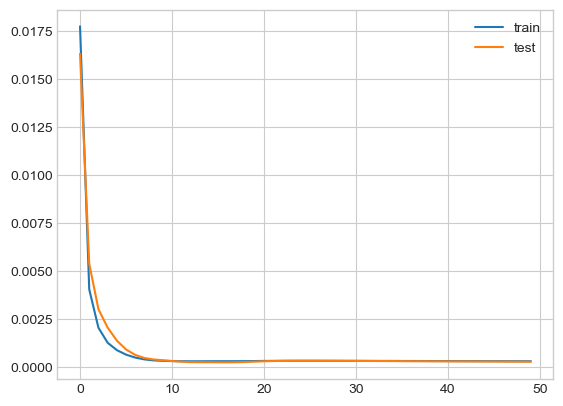

In [38]:
model = Sequential()
model.add(SimpleRNN(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(val_X, val_y), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [39]:
inv_test_y, inv_pred_y = evaluate_model(model, scaler, test_X, test_y)

297/297 [==============================] - 1s 3ms/step
Test RMSE: 0.920


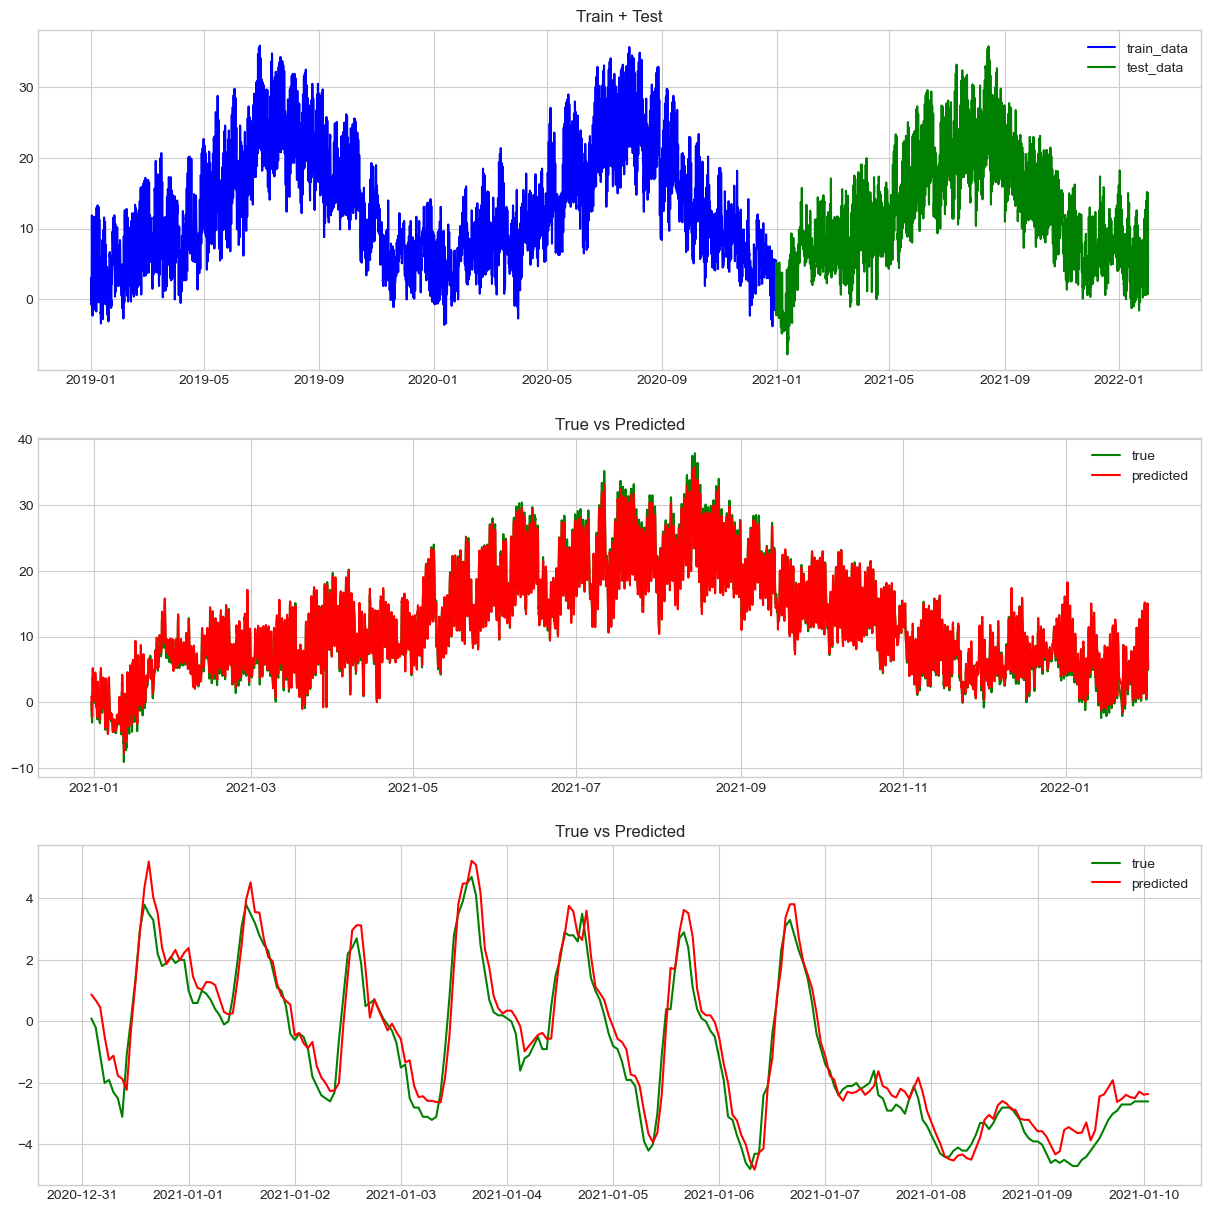

In [40]:
visualize_predictions(reframed.index, n_train_hours, inv_train_y, inv_test_y, inv_pred_y)

#### LSTM RNN 

Epoch 1/50
240/240 - 9s - loss: 0.0197 - val_loss: 0.0408 - 9s/epoch - 38ms/step
Epoch 2/50
240/240 - 1s - loss: 0.0087 - val_loss: 0.0240 - 988ms/epoch - 4ms/step
Epoch 3/50
240/240 - 1s - loss: 0.0056 - val_loss: 0.0147 - 1s/epoch - 4ms/step
Epoch 4/50
240/240 - 1s - loss: 0.0037 - val_loss: 0.0093 - 1s/epoch - 5ms/step
Epoch 5/50
240/240 - 1s - loss: 0.0026 - val_loss: 0.0061 - 1s/epoch - 5ms/step
Epoch 6/50
240/240 - 1s - loss: 0.0020 - val_loss: 0.0042 - 1s/epoch - 5ms/step
Epoch 7/50
240/240 - 1s - loss: 0.0015 - val_loss: 0.0030 - 1s/epoch - 5ms/step
Epoch 8/50
240/240 - 1s - loss: 0.0012 - val_loss: 0.0023 - 1s/epoch - 5ms/step
Epoch 9/50
240/240 - 1s - loss: 9.5288e-04 - val_loss: 0.0018 - 1s/epoch - 5ms/step
Epoch 10/50
240/240 - 1s - loss: 7.7943e-04 - val_loss: 0.0014 - 1s/epoch - 5ms/step
Epoch 11/50
240/240 - 1s - loss: 6.4599e-04 - val_loss: 0.0012 - 1s/epoch - 5ms/step
Epoch 12/50
240/240 - 1s - loss: 5.4318e-04 - val_loss: 0.0010 - 1s/epoch - 4ms/step
Epoch 13/50
240/2

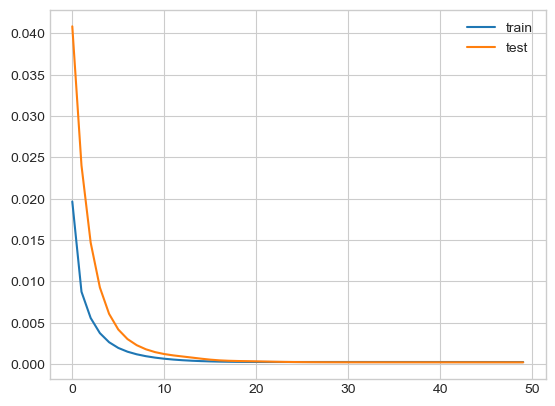

In [41]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(val_X, val_y), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [42]:
inv_test_y, inv_pred_y = evaluate_model(model, scaler, test_X, test_y)

297/297 [==============================] - 3s 3ms/step
Test RMSE: 0.922


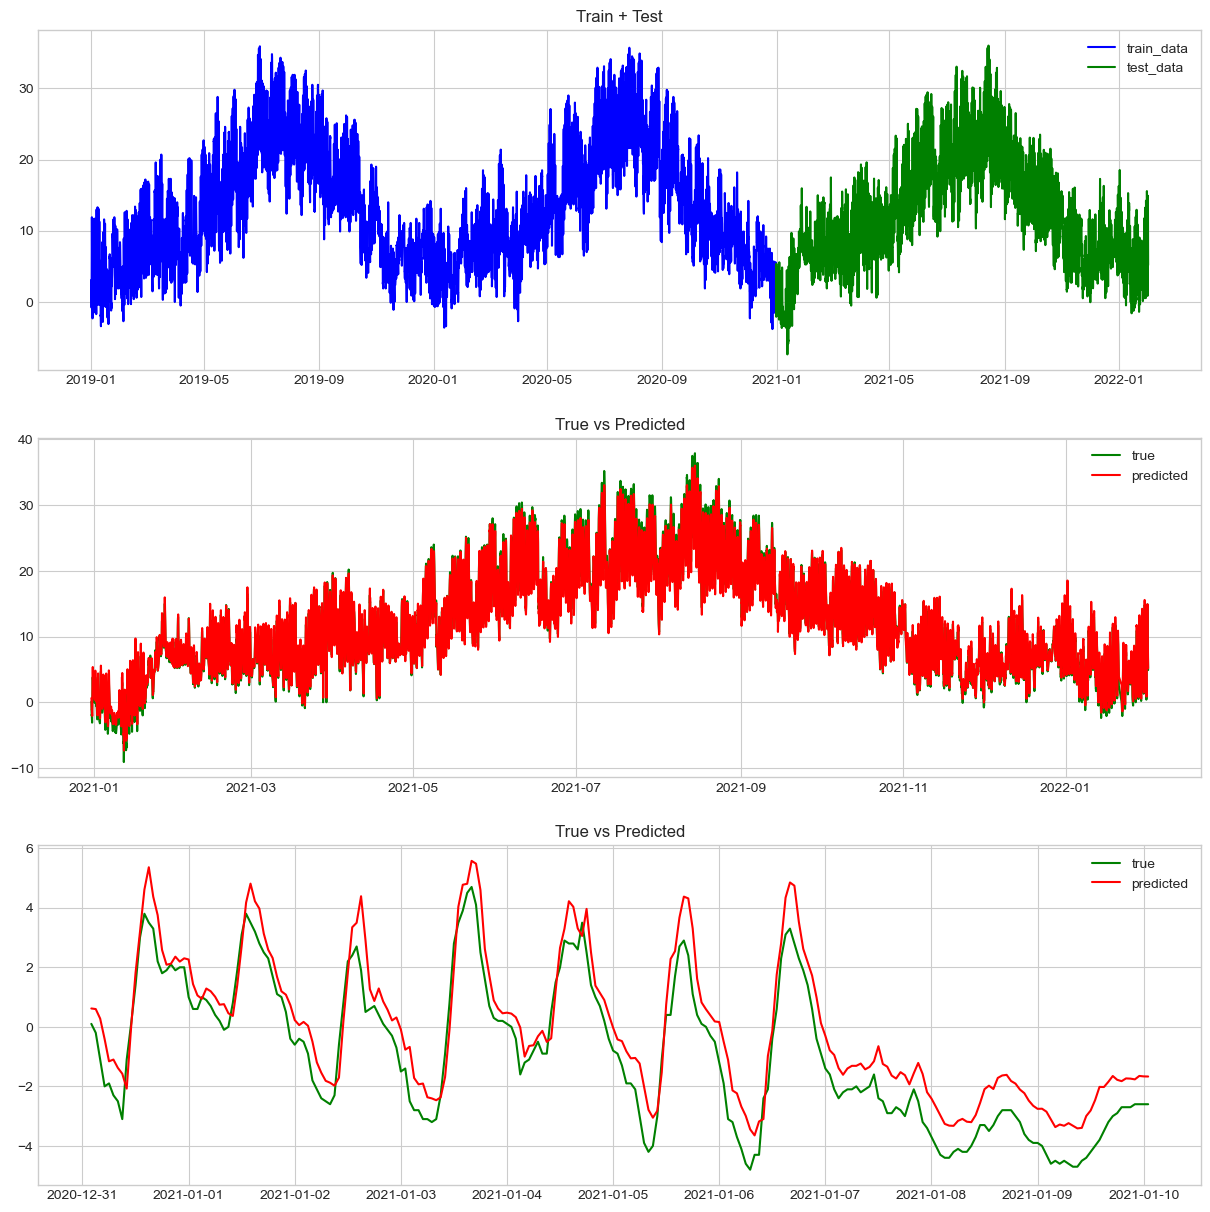

In [43]:
visualize_predictions(reframed.index, n_train_hours, inv_train_y, inv_test_y, inv_pred_y)

#### GRU RNN

Epoch 1/50
240/240 - 10s - loss: 0.0120 - val_loss: 0.0169 - 10s/epoch - 40ms/step
Epoch 2/50
240/240 - 1s - loss: 0.0045 - val_loss: 0.0083 - 1s/epoch - 5ms/step
Epoch 3/50
240/240 - 1s - loss: 0.0028 - val_loss: 0.0048 - 1s/epoch - 5ms/step
Epoch 4/50
240/240 - 1s - loss: 0.0019 - val_loss: 0.0031 - 1s/epoch - 5ms/step
Epoch 5/50
240/240 - 1s - loss: 0.0013 - val_loss: 0.0022 - 965ms/epoch - 4ms/step
Epoch 6/50
240/240 - 1s - loss: 9.5185e-04 - val_loss: 0.0017 - 1s/epoch - 6ms/step
Epoch 7/50
240/240 - 1s - loss: 7.1244e-04 - val_loss: 0.0013 - 1s/epoch - 4ms/step
Epoch 8/50
240/240 - 1s - loss: 5.4560e-04 - val_loss: 9.7445e-04 - 1s/epoch - 4ms/step
Epoch 9/50
240/240 - 1s - loss: 4.2930e-04 - val_loss: 6.9293e-04 - 1s/epoch - 5ms/step
Epoch 10/50
240/240 - 1s - loss: 3.5186e-04 - val_loss: 5.1319e-04 - 1s/epoch - 5ms/step
Epoch 11/50
240/240 - 1s - loss: 3.0459e-04 - val_loss: 4.1533e-04 - 1s/epoch - 4ms/step
Epoch 12/50
240/240 - 1s - loss: 2.7969e-04 - val_loss: 3.6479e-04 - 1s/

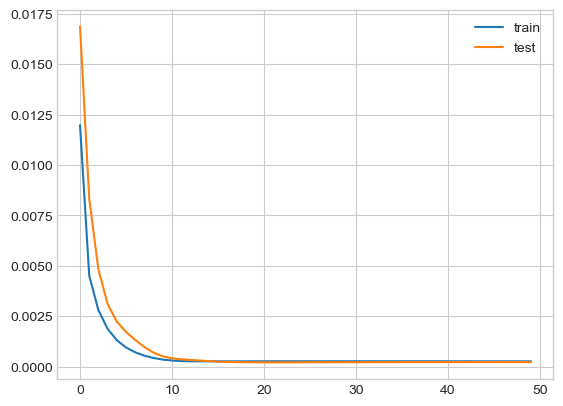

In [44]:
model = Sequential()
model.add(GRU(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(val_X, val_y), verbose=2, shuffle=False)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [45]:
inv_test_y, inv_pred_y = evaluate_model(model, scaler, test_X, test_y)

297/297 [==============================] - 2s 3ms/step
Test RMSE: 0.936


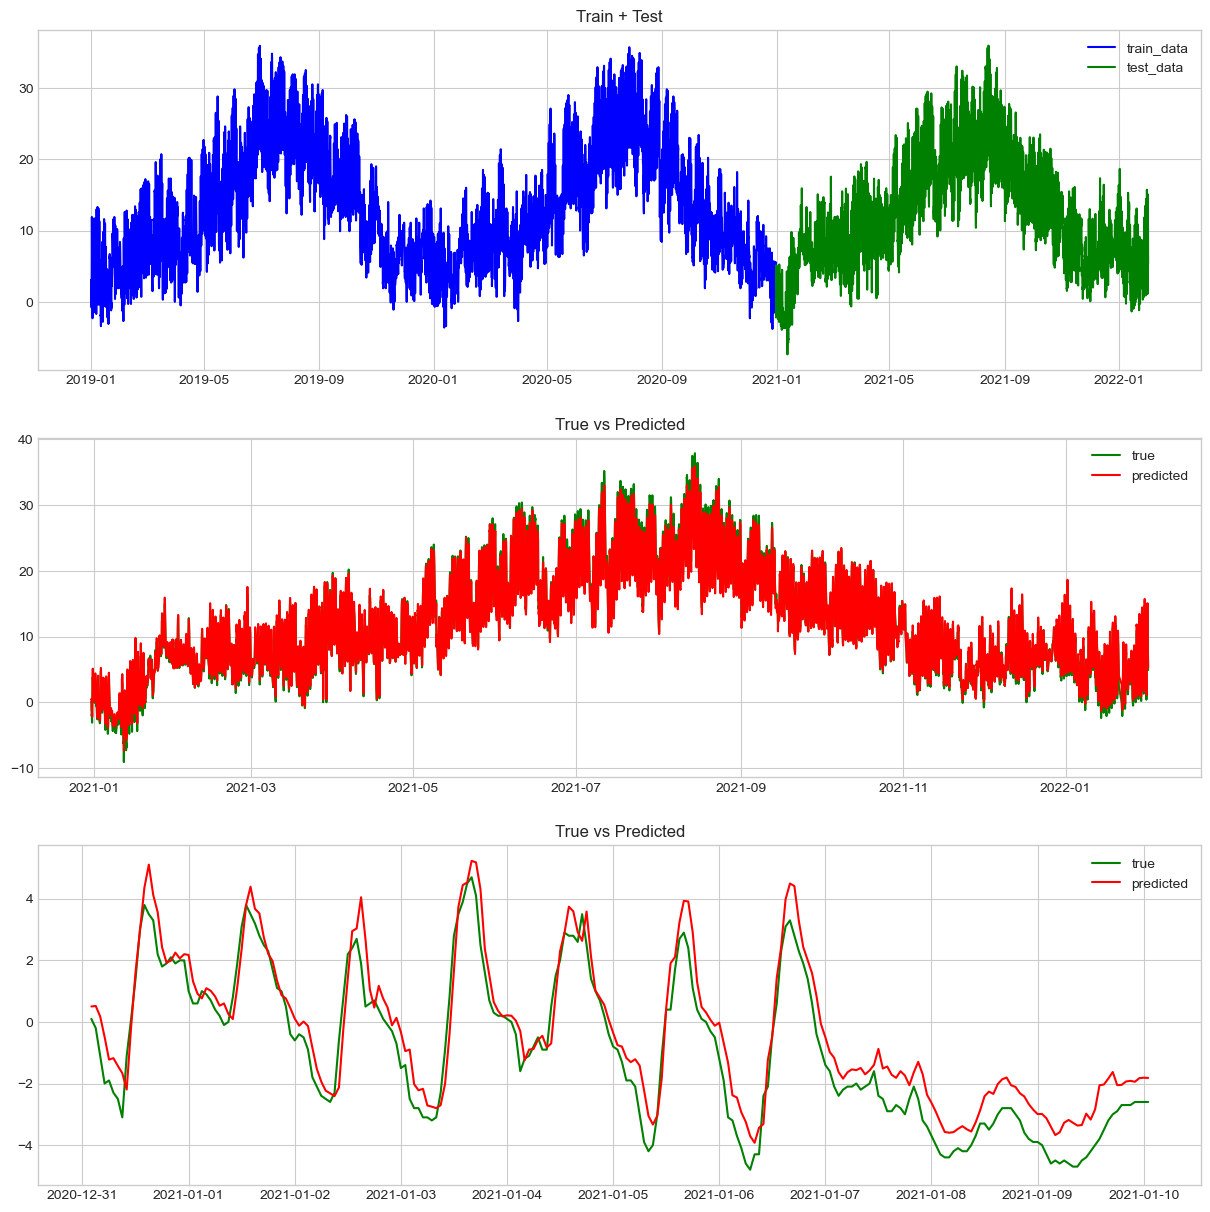

In [46]:
visualize_predictions(reframed.index, n_train_hours, inv_train_y, inv_test_y, inv_pred_y)